# Chapter 27: Regression

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("Chapter27").getOrCreate()

In [2]:
df = spark.read.load("../data/regression")
df.show()  # it is a very small dataset!

train_df, test_df = df.randomSplit([0.7, 0.3])

+--------------+-----+
|      features|label|
+--------------+-----+
|[3.0,10.1,3.0]|  2.0|
| [2.0,1.1,1.0]|  1.0|
|[1.0,0.1,-1.0]|  0.0|
|[1.0,0.1,-1.0]|  0.0|
| [2.0,4.1,1.0]|  2.0|
+--------------+-----+



## Linear Regression

For the current version of spark 2.4, the API can be consulted here for the both the estimator, model and summary [API docs for Linear Regression](http://spark.apache.org/docs/2.4.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.LinearRegression)

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.8)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0, current: 0.3)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the tr

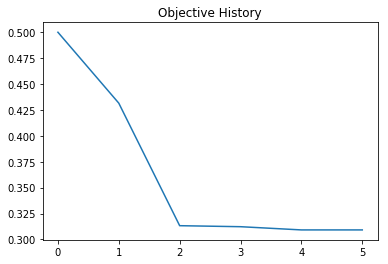

RMS error = 0.47308424392175996
R2 = 0.7202391226912209


In [3]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression().setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)
print (lr.explainParams())  # explain acceptable parameters
lrModel = lr.fit(df)  # fit input data, all of it, in this case

# training summary
summary = lrModel.summary
summary.residuals.show()

print("Total iterations = {}".format(summary.totalIterations))

import matplotlib.pyplot as plt
plt.plot(summary.objectiveHistory)
plt.title("Objective History")
plt.show()

print("RMS error = {}".format(summary.rootMeanSquaredError))
print("R2 = {}".format(summary.r2))

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator

def evaluate_model(model):
    print("Evaluating model on train and test datasets...")
    for k, d in {"train data":train_df, "test data":test_df}.items():
        print(k)
        df_pred = model.transform(d)
        reg_eval = RegressionEvaluator(predictionCol="prediction")
        for metric in ["mse", "r2", "mae", "rmse"]:
            print("{} on {} = {}".format(metric, k, reg_eval.evaluate(df_pred, {reg_eval.metricName:metric})))
            
evaluate_model(lrModel)                                  

Evaluating model on train and test datasets...
train data
mse on train data = 0.255952423848516
r2 on train data = -0.1517859073183221
mae on train data = 0.37581401255995095
rmse on train data = 0.5059174081295444
test data
mse on test data = 0.175593118844784
r2 on test data = -inf
mae on test data = 0.41903832622420595
rmse on test data = 0.4190383262242059


## Generalized Linear Regression

API can be consulted [here](http://spark.apache.org/docs/2.4.0/api/python/pyspark.ml.html?highlight=linearregression#pyspark.ml.regression.GeneralizedLinearRegression)


In [6]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3, linkPredictionCol="linkOut")
print(glr.explainParams())
glr_model = glr.fit(df)

evaluate_model(glr_model)

family: The name of family which is a description of the error distribution to be used in the model. Supported options: gaussian (default), binomial, poisson, gamma and tweedie. (default: gaussian, current: gaussian)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
link: The name of link function which provides the relationship between the linear predictor and the mean of the distribution function. Supported options: identity, log, inverse, logit, probit, cloglog and sqrt. (current: identity)
linkPower: The index in the power link function. Only applicable to the Tweedie family. (undefined)
linkPredictionCol: link prediction (linear predictor) column name (current: linkOut)
maxIter: max number of iterations (>= 0). (default: 25, current: 10)
offsetCol: The offset column name. If this is not set or empty, we treat all instance offsets as 0.0 (undefined)
predictionCol: pred

## Decision Trees (CART)

In [7]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
print(dtr.explainParams())
dtrModel = dtr.fit(df)
evaluate_model(dtrModel)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. 

# Random Forests and Gradient-Boosted Trees

In [8]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor()
rfModel = rf.fit(df)
evaluate_model(rfModel)

Evaluating model on train and test datasets...
train data
mse on train data = 0.10712962962962964
r2 on train data = 0.5179166666666666
mae on train data = 0.3166666666666667
rmse on train data = 0.32730662937012084
test data
mse on test data = 0.01361111111111111
r2 on test data = -inf
mae on test data = 0.11666666666666665
rmse on test data = 0.11666666666666667


In [9]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor()
gbtModel = gbt.fit(df)
evaluate_model(gbtModel)

Evaluating model on train and test datasets...
train data
mse on train data = 0.0
r2 on train data = 1.0
mae on train data = 0.0
rmse on train data = 0.0
test data
mse on test data = 0.0
r2 on test data = nan
mae on test data = 0.0
rmse on test data = 0.0


# Regression pipeline

In [23]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

glr = GeneralizedLinearRegression(family="gaussian", link="identity")
pipeline = Pipeline(stages=[glr])
grid = ParamGridBuilder().addGrid(glr.regParam, [0, 1]).build()
evaluator = RegressionEvaluator(metricName="rmse", predictionCol="prediction", labelCol="label")
cv = CrossValidator(estimator=glr, evaluator=evaluator, numFolds=2, estimatorParamMaps=grid)
model = cv.fit(df)

Py4JJavaError: An error occurred while calling o7954.w.
: java.lang.ClassCastException


In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors

dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
pipeline = Pipeline(stages=[lr])
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=grid, evaluator=evaluator, parallelism=2)
cvModel = cv.fit(dataset)

In [24]:
df

DataFrame[features: vector, label: double]

In [25]:
df.show()

+--------------+-----+
|      features|label|
+--------------+-----+
|[3.0,10.1,3.0]|  2.0|
| [2.0,1.1,1.0]|  1.0|
|[1.0,0.1,-1.0]|  0.0|
|[1.0,0.1,-1.0]|  0.0|
| [2.0,4.1,1.0]|  2.0|
+--------------+-----+

